# Importing all necessary files

In [ ]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import os
from sklearn.manifold import TSNE
import torch
import torchvision.transforms as transforms
from PIL import Image
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional
from tensorflow.keras.models import Sequential
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, LSTM, concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

In [ ]:
# Set the GPU device
#os.environ['CUDA_VISIBLE_DEVICES'] = '0' # Use GPU 0
# Create a TensorFlow session
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#sess = tf.Session(config=config)

# Loading Clip Model

In [ ]:
# Load CLIP model and tokenizer
model_name = 'openai/clip-vit-base-patch32'
model = CLIPModel.from_pretrained(model_name)
tokenizer = CLIPProcessor.from_pretrained(model_name)

# Fetching data set

In [ ]:
train = pd.read_json("data/train.jsonl", lines=True)
val = pd.read_json("data/dev_seen.jsonl", lines=True)
test = pd.read_json("data/test_seen.jsonl", lines=True)

In [ ]:
train

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."
...,...,...,...,...
8495,10423,img/10423.png,1,nobody wants to hang auschwitz me
8496,98203,img/98203.png,1,when god grants you a child after 20 years of ...
8497,36947,img/36947.png,1,gays on social media: equality! body positivit...
8498,16492,img/16492.png,1,having a bad day? you could be a siamese twin ...


# Reducing Train Test and Val data set for faster preprocessing

In [ ]:
train_l = train['label']
train.drop(['label'], axis=1, inplace=True)

In [ ]:
tx,train,ty,train_label = train_test_split(train, train_l, stratify = train_l, test_size=0.10)

In [ ]:
len(train)

850

In [ ]:
train

,id,img,text
2990,64957,img/64957.png,when your dishwasher is ready for another load
1732,79680,img/79680.png,when you finally graduate in a school in the usa
6328,58109,img/58109.png,no to transphobes give trans people peace
2602,87695,img/87695.png,dark humor is like him '' it never gets old
4350,48706,img/48706.png,would you help give a push if you were ask
...,...,...,...
8181,17698,img/17698.png,when the black kids start fighting at school
755,63871,img/63871.png,you can be any gender you want if you are ment...
7876,47516,img/47516.png,a dictator.. emphasis on the dic*
7382,48120,img/48120.png,rise of the planet of the apes (1963


In [ ]:
train_text = []
for i in np.array(train['text']):
    train_text.append(i)

In [ ]:
len(train_text)

850

In [ ]:
test

,id,img,label,text
0,16395,img/16395.png,1,handjobs sold seperately
1,37405,img/37405.png,1,introducing fidget spinner for women
2,94180,img/94180.png,1,happy pride month let's go beat up lesbians
3,54321,img/54321.png,1,laughs in [majority of u.s crime rate]
4,97015,img/97015.png,1,finds out those 72 virgins.. are goats
...,...,...,...,...
995,3869,img/03869.png,0,a mother's love for the child is a divine thing
996,23817,img/23817.png,0,sea monkeys
997,56280,img/56280.png,0,little miss muffet sat on her tuffet
998,29384,img/29384.png,0,they're in a row


In [ ]:
test_l = test['label']
test.drop(['label'], axis=1, inplace=True)

In [ ]:
tx,test,ty,test_label = train_test_split(test, test_l, stratify = test_l, test_size=0.99)

In [ ]:
test_text = []
for i in np.array(test['text']):
    test_text.append(i)

In [ ]:
len(test_text)

990

In [ ]:
val

,id,img,label,text
0,8291,img/08291.png,1,white people is this a shooting range
1,46971,img/46971.png,1,bravery at its finest
2,3745,img/03745.png,1,your order comes to $37.50 and your white priv...
3,83745,img/83745.png,1,it is time.. to send these parasites back to t...
4,80243,img/80243.png,1,mississippi wind chime
...,...,...,...,...
495,83675,img/83675.png,0,i'm gonna be like phelps one day
496,37198,img/37198.png,0,when you're so relaxed you can feel yourself g...
497,48670,img/48670.png,0,look at this sandwich maker club i found on wi...
498,9863,img/09863.png,0,diverse group of women


In [ ]:
val_l = val['label']
val.drop(['label'], axis=1, inplace=True)

In [ ]:
tx,val,ty,val_label = train_test_split(val, val_l, stratify = val_l, test_size=0.10)

In [ ]:
val_text = []
for i in np.array(val['text']):
    val_text.append(i)

In [ ]:
len(val_text)

50

# Preprocessing text data

In [ ]:
# Tokenize text and get embeddings
text_tokens = tokenizer(train_text, padding=True, truncation=True, return_tensors="pt")
train_text_embedding = model.get_text_features(text_tokens['input_ids'], text_tokens['attention_mask'])

In [ ]:
train_text_embedding = train_text_embedding.detach().numpy()

In [ ]:
# Tokenize text and get embeddings
text_tokens = tokenizer(val_text, padding=True, truncation=True, return_tensors="pt")
val_text_embedding = model.get_text_features(text_tokens['input_ids'], text_tokens['attention_mask'])

In [ ]:
val_text_embedding = val_text_embedding.detach().numpy()

In [ ]:
# Tokenize text and get embeddings
text_tokens = tokenizer(test_text, padding=True, truncation=True, return_tensors="pt")
test_text_embedding = model.get_text_features(text_tokens['input_ids'], text_tokens['attention_mask'])

In [ ]:
test_text_embedding = test_text_embedding.detach().numpy()

# Preporcessing image data

In [ ]:
# Get image embeddings
test_image_embedding = []
for img_url in np.array(test['img']):
    # Load image
    img_path = 'data/'+ img_url
    img = Image.open(img_path).convert('RGB')
    img = np.array(img)

    # Preprocess image
    img = Image.fromarray(np.uint8(img)).resize((224, 224))
    img = np.array(img).astype(np.float32) / 255.0
    img = (img - 0.5) / 0.5
    img = np.transpose(img, (2, 0, 1))

    # Get image embedding
    image_tensor = torch.tensor(img).unsqueeze(0)
    image_embedding = model.get_image_features(image_tensor)
    test_image_embedding.append(image_embedding.detach().numpy())

In [ ]:
test_image_embedding = np.vstack(test_image_embedding)

In [ ]:
# Get image embeddings
train_image_embedding = []
for img_url in np.array(train['img']):
    # Load image
    img_path = 'data/'+ img_url
    img = Image.open(img_path).convert('RGB')
    img = np.array(img)

    # Preprocess image
    img = Image.fromarray(np.uint8(img)).resize((224, 224))
    img = np.array(img).astype(np.float32) / 255.0
    img = (img - 0.5) / 0.5
    img = np.transpose(img, (2, 0, 1))

    # Get image embedding
    image_tensor = torch.tensor(img).unsqueeze(0)
    image_embedding = model.get_image_features(image_tensor)
    train_image_embedding.append(image_embedding.detach().numpy())

In [ ]:
train_image_embedding = np.vstack(train_image_embedding)

In [ ]:
# Get image embeddings
val_image_embedding = []
for img_url in np.array(val['img']):
    # Load image
    img_path = 'data/'+ img_url
    img = Image.open(img_path).convert('RGB')
    img = np.array(img)

    # Preprocess image
    img = Image.fromarray(np.uint8(img)).resize((224, 224))
    img = np.array(img).astype(np.float32) / 255.0
    img = (img - 0.5) / 0.5
    img = np.transpose(img, (2, 0, 1))

    # Get image embedding
    image_tensor = torch.tensor(img).unsqueeze(0)
    image_embedding = model.get_image_features(image_tensor)
    val_image_embedding.append(image_embedding.detach().numpy())

In [ ]:
val_image_embedding = np.vstack(val_image_embedding)

# Building architecture for final classification

In [ ]:
# create text embedding model
text_input = layers.Input(shape=(512,))
text_layer1 = layers.Dense(128, activation='relu')(text_input)
text_layer2 = layers.Dense(64, activation='relu')(text_layer1)
text_output = layers.Dense(32, activation='relu')(text_layer2)
text_model = tf.keras.Model(inputs=text_input, outputs=text_output)

# create image embedding model
image_input = layers.Input(shape=(512,))
image_layer1 = layers.Dense(128, activation='relu')(image_input)
image_layer2 = layers.Dense(64, activation='relu')(image_layer1)
image_output = layers.Dense(32, activation='relu')(image_layer2)
image_model = tf.keras.Model(inputs=image_input, outputs=image_output)

# concatenate the two models
concatenated = layers.concatenate([text_model.output, image_model.output])
concatenated_layer = layers.Dense(32, activation='relu')(concatenated)
output_layer = layers.Dense(2, activation='sigmoid')(concatenated_layer)
model = tf.keras.Model(inputs=[text_model.input, image_model.input], outputs=output_layer)

In [ ]:
aucroc = tf.keras.metrics.AUC(curve='ROC')

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# train the model
model_history = model.fit([train_text_embedding,train_image_embedding], train_label, epochs=10, batch_size=32,validation_data=([val_text_embedding,val_image_embedding],val_label))

Epoch 1/10
27/27 [==============================] - 1s 11ms/step - loss: 0.6433 - accuracy: 0.6494 - val_loss: 0.7393 - val_accuracy: 0.5200
Epoch 2/10
27/27 [==============================] - 0s 3ms/step - loss: 0.5186 - accuracy: 0.7471 - val_loss: 0.7256 - val_accuracy: 0.6400
Epoch 3/10
27/27 [==============================] - 0s 3ms/step - loss: 0.3880 - accuracy: 0.8282 - val_loss: 0.8071 - val_accuracy: 0.5800
Epoch 4/10
27/27 [==============================] - 0s 3ms/step - loss: 0.2185 - accuracy: 0.9294 - val_loss: 1.1598 - val_accuracy: 0.5200
Epoch 5/10
27/27 [==============================] - 0s 4ms/step - loss: 0.0923 - accuracy: 0.9729 - val_loss: 1.0730 - val_accuracy: 0.6200
Epoch 6/10
27/27 [==============================] - 0s 4ms/step - loss: 0.0264 - accuracy: 0.9988 - val_loss: 1.5693 - val_accuracy: 0.5200
Epoch 7/10
27/27 [==============================] - 0s 4ms/step - loss: 0.0128 - accuracy: 0.9988 - val_loss: 1.7878 - val_accuracy: 0.5600
Epoch 8/10
27/27 [=

# Graphs for Final Model

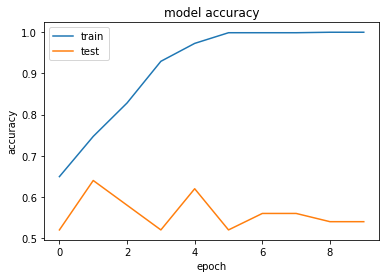

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

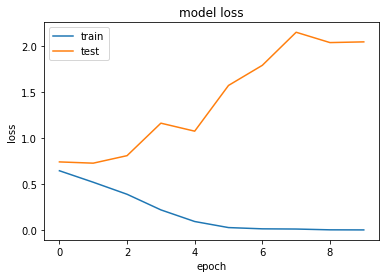

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Save Model and Fetch Model

In [ ]:
model.save('Final_Clip_Model.h5')

In [ ]:
model = load_model('Final_Clip_Model.h5')

# Classwise prediction for test data

In [ ]:
predictions = model.predict([test_image_embedding,test_text_embedding])
y_pred = np.argmax(predictions, axis = 1)
y_true = test_label

31/31 [==============================] - 0s 2ms/step


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.69      0.62       505
           1       0.57      0.43      0.49       485

    accuracy                           0.56       990
   macro avg       0.57      0.56      0.55       990
weighted avg       0.57      0.56      0.56       990



In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate([test_image_embedding,test_text_embedding], test_label)
print('Accuracy: ', accuracy)

31/31 [==============================] - 0s 2ms/step - loss: 1.3859 - accuracy: 0.5636
Accuracy:  0.5636363625526428


# Last layer prediction of clip model for TSNE

In [ ]:
non_hateful = pd.read_csv('tsne_test_class0.csv')
hateful = pd.read_csv('tsne_test_class1.csv')

In [ ]:
non_hateful_text = []
for i in np.array(non_hateful['text']):
    non_hateful_text.append(i)

In [ ]:
hateful_text = []
for i in np.array(hateful['text']):
    hateful_text.append(i)

In [ ]:
# Tokenize text and get embeddings
hateful_text_tokens = tokenizer(hateful_text, padding=True, truncation=True, return_tensors="pt")
hateful_text_embeddings = model.get_text_features(hateful_text_tokens['input_ids'], hateful_text_tokens['attention_mask'])

In [ ]:
hateful_text_embeddings = hateful_text_embeddings.detach().numpy()

In [ ]:
# Tokenize text and get embeddings
non_hateful_text_tokens = tokenizer(non_hateful_text, padding=True, truncation=True, return_tensors="pt")
non_hateful_text_embeddings = model.get_text_features(non_hateful_text_tokens['input_ids'], non_hateful_text_tokens['attention_mask'])

In [ ]:
non_hateful_text_embeddings = non_hateful_text_embeddings.detach().numpy()

In [ ]:
# Get image embeddings
hateful_image_embedding = []
for img_url in np.array(hateful['img']):
    # Load image
    img_path = 'data/'+ img_url
    img = Image.open(img_path).convert('RGB')
    img = np.array(img)

    # Preprocess image
    img = Image.fromarray(np.uint8(img)).resize((224, 224))
    img = np.array(img).astype(np.float32) / 255.0
    img = (img - 0.5) / 0.5
    img = np.transpose(img, (2, 0, 1))

    # Get image embedding
    image_tensor = torch.tensor(img).unsqueeze(0)
    image_embedding = model.get_image_features(image_tensor)
    hateful_image_embedding.append(image_embedding.detach().numpy())

In [ ]:
hateful_image_embedding = np.vstack(hateful_image_embedding)

In [ ]:
# Get image embeddings
non_hateful_image_embedding = []
for img_url in np.array(non_hateful['img']):
    # Load image
    img_path = 'data/'+ img_url
    img = Image.open(img_path).convert('RGB')
    img = np.array(img)

    # Preprocess image
    img = Image.fromarray(np.uint8(img)).resize((224, 224))
    img = np.array(img).astype(np.float32) / 255.0
    img = (img - 0.5) / 0.5
    img = np.transpose(img, (2, 0, 1))

    # Get image embedding
    image_tensor = torch.tensor(img).unsqueeze(0)
    image_embedding = model.get_image_features(image_tensor)
    non_hateful_image_embedding.append(image_embedding.detach().numpy())

In [ ]:
non_hateful_image_embedding = np.vstack(non_hateful_image_embedding)

In [ ]:
model = load_model('Final_Clip_Model.h5')

In [ ]:
last_layer_model = Model(inputs=model.input, outputs=model.layers[-2].output)

In [ ]:
hateful_features = last_layer_model.predict([hateful_image_embedding,hateful_text_embeddings])

2/2 [==============================] - 1s 16ms/step


In [ ]:
non_hateful_features = last_layer_model.predict([non_hateful_image_embedding,non_hateful_text_embeddings])

2/2 [==============================] - 0s 20ms/step


In [ ]:
np.save('Clip_hateful_features.npy', hateful_features)
np.save('Clip_non_hateful_features.npy', non_hateful_features)
np.save('Clip_hateful_label.npy',hateful['label'])
np.save('Clip_non_hateful_label.npy',non_hateful['label'])

In [ ]:
hateful_features = np.load('Clip_hateful_features.npy')
hateful_label = np.load('Clip_hateful_label.npy')
non_hateful_features = np.load('Clip_non_hateful_features.npy')
non_hateful_label = np.load('Clip_non_hateful_label.npy')

# Visualization of CLIP Model for TSNE

In [ ]:
# Perform t-SNE dimensionality reduction on the features
tsne = TSNE(n_components=2, random_state=42)
tsne_hateful_features = tsne.fit_transform(hateful_features)
tsne_non_hateful_features = tsne.fit_transform(non_hateful_features)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


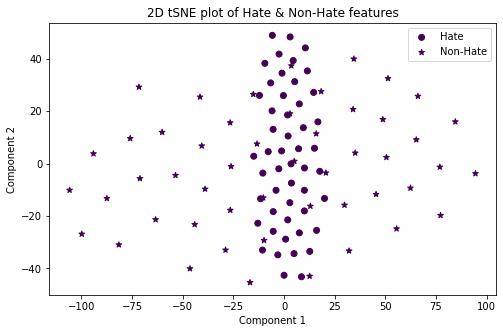

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(tsne_hateful_features[:,0], tsne_hateful_features[:,1], c=hateful_label, marker='o')
plt.scatter(tsne_non_hateful_features[:,0], tsne_non_hateful_features[:,1], c=non_hateful_label, marker='*')

plt.xlabel("Component 1")
plt.ylabel("Component 2")

plt.title("2D tSNE plot of Hate & Non-Hate features")
plt.legend(['Hate','Non-Hate'])